In [9]:
%pip install tensorflow
%pip install tensorflow-datasets
%pip install scipy
%pip install pandas
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv2D,Dropout,MaxPool2D
import tensorflow.keras.optimizers 
import numpy as np
import random

## load the data
(train, test) = tfds.load(
    'svhn_cropped',
    split=['train','test'],
    shuffle_files = True,
    as_supervised = True,
)

random.seed(42)
tf.random.set_seed(42)
np.random.seed(42)

In [11]:
train = train.take(2000)
test = test.take(500)

## normalize data [0,1]
def normalize_img(img,label):
    normalized_img = tf.cast(img, tf.float32) / 255
    return normalized_img, label

train_normalized = train.map(normalize_img)
test_normalized = test.map(normalize_img)

train_normalized = train_normalized.shuffle(2000).batch(32)
test_normalized = test_normalized.batch(32)

In [12]:
## buid the network
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(32,32,3)),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(10, activation='softmax')
])

/Users/daviddevoldpearson/take-2-ML-3/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
SGD_optimizer = tensorflow.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy',optimizer=SGD_optimizer,metrics=['accuracy'])
history = model.fit(train_normalized,epochs=15, validation_data=test_normalized)


Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1865 - loss: 2.2581 - val_accuracy: 0.1840 - val_loss: 2.2563
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1955 - loss: 2.2465 - val_accuracy: 0.1840 - val_loss: 2.2499
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1950 - loss: 2.2407 - val_accuracy: 0.1840 - val_loss: 2.2588
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1950 - loss: 2.2412 - val_accuracy: 0.1840 - val_loss: 2.2479
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1955 - loss: 2.2372 - val_accuracy: 0.1840 - val_loss: 2.2388
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1960 - loss: 2.2217 - val_accuracy: 0.1840 - val_loss: 2.2269
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2060 - loss: 2.1954 - val_accuracy: 0.2000 - val_loss: 2.1931
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2375 - loss: 2.1250 - val_accuracy: 0.3020 - val_loss:

In [14]:
test_accuracy = model.evaluate(test_normalized)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7000 - loss: 1.0074 


In [15]:

true_labels = []

## since not split in X and Y, have to split 
for X_batch, Y_batch in test_normalized:
    true_labels.append(Y_batch)
    
y_true = np.concatenate(true_labels, axis=0)

## montecarlo
forward_passes = 20
predictions = []
for n in range(forward_passes):
    forward_pass_prediction = []

    for X_batch, Y_batch in test_normalized:
        y_pred = model(X_batch, training=True)
        forward_pass_prediction.append(y_pred.numpy())
    
    predictions.append(np.concatenate(forward_pass_prediction, axis=0))

predictions = np.stack(predictions, axis=0)
mean_prediction = predictions.mean(axis=0)
y_pred_classes = np.argmax(mean_prediction, axis=1)
mc_dropout_accuracy = np.mean(y_pred_classes == y_true)


print("accuracy:", mc_dropout_accuracy)
epistemic_uncertainty = np.var(predictions, axis=0)
epistemic_uncertainty = epistemic_uncertainty.mean(axis=1)
epistemic_true_mean = epistemic_uncertainty.mean()
print("epistemic uncertainty:", round(epistemic_true_mean,3))

2025-11-06 22:24:57.929685: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


accuracy: 0.692
epistemic uncertainty: 0.003


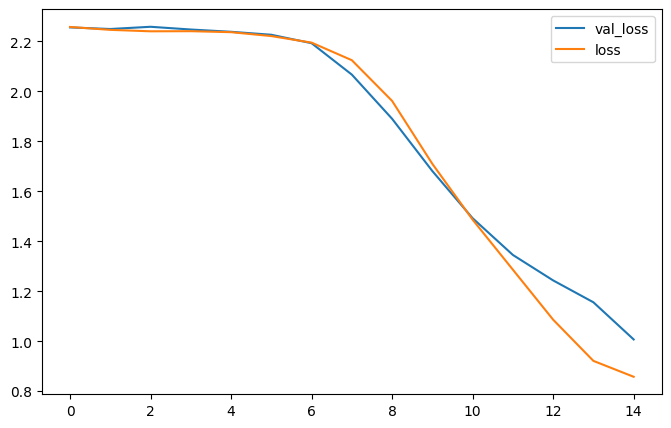

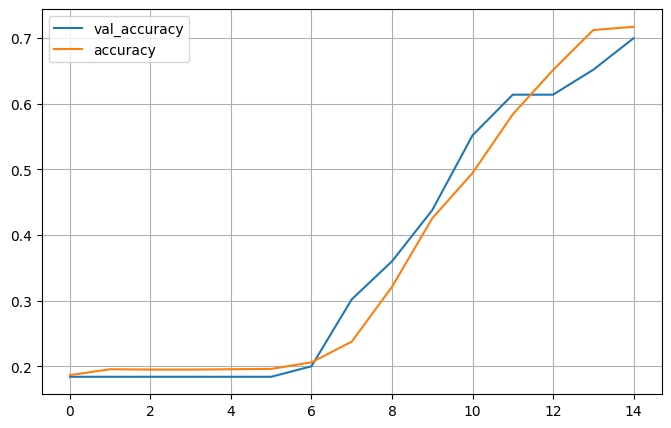

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

dataframe = pd.DataFrame(history.history)
dataframe[['val_loss', 'loss']].plot(figsize=(8,5))
dataframe[['val_accuracy', 'accuracy']].plot(figsize=(8,5))
plt.grid(True)
plt.show()